# Openpiv-python-gpu - Basic Tutorial

Use the following link to run this using GPUs from Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericyang125/openpiv-python-gpu/blob/main/openpiv/tutorials/openpiv_python_gpu_tutorial_basic.ipynb)

Ensure that GPU acceleration is enabled in Google Colab: Runtime > Change runtime type.

## Introduction

This tutorial will demonstrate how to use the GPU functionality of openpiv-python-gpu. OpenPIV will be installed to this VM and a single image pair will be processed.

## GPU-accelerated PIV functions

PIV functionality is provided by a PIV class and a wrapper function for it. The APIs are given below.

### openpiv.gpu.process.piv(frame_a, frame_b, **kwargs):

    """Convenience wrapper-function for PIV.

    Parameters
    ----------
    frame_a, frame_b : ndarray
        2D int (ht, wd), grey levels of the first and second frames.
    return_s2n : bool
        Sets whether to return the signal-to-noise ratio. Not returning the
        signal-to-noise speeds up computation significantly, which is default behaviour.
    **kwargs
        PIV settings. See PIVGPU.

    Returns
    -------
    x : ndarray
        2D float (m, n), x-coordinates where the velocity field has been computed.
    y : ndarray
        2D float (m, n), y-coordinates where the velocity field has been computed.
    u : ndarray
        2D float (m, n), horizontal component of velocity in pixel/time units.
    v : ndarray
        2D float (m, n), vertical component of velocity in pixel/time units.
    mask : ndarray
        2D int (m, n), boolean values (True for vectors interpolated from previous
        iteration).
    s2n : ndarray
        2D float (m, n), signal-to-noise ratio of the final velocity field.

    Example
    -------
    x, y, u, v, mask, s2n = gpu_piv(
        frame_a,
        frame_b,
        mask=None,
        window_size_iters=(1, 2),
        min_window_size=16,
        overlap_ratio=0.5,
        dt=1,
        deform=True,
        smooth=True,
        nb_validation_iter=2,
        validation_method='median_velocity',
        median_tol=2
    )

    """

### openpiv.gpu.process.PIV:

    """Iterative GPU-accelerated algorithm that uses translation and deformation of
    interrogation windows.

    At every iteration, the estimate of the displacement and gradient are used to shift
    and deform the interrogation windows used during the next iteration. One or more
    iterations can be performed before the estimated velocity is interpolated onto a
    finer mesh. This is done until the final mesh and number of iterations is met.

    Algorithm Details
    -----------------
    Only window sizes that are multiples of 8 are supported now, and the minimum window
    size is 8.
    Windows are shifted symmetrically to reduce bias errors.
    The displacement obtained after each correlation is the residual displacement dc.
    The new displacement is computed by dx = dpx + dcx and dy = dpy + dcy.
    Validation is done by any combination of signal-to-noise ratio, mean, median and rms
    velocities.
    Smoothn can be used between iterations to improve the estimate and replace missing
    values.

    References
    ----------
    Scarano F, Riethmuller ML (1999) Iterative multigrid approach in PIV image
        processing with discrete window offset.
        Exp Fluids 26:513–523
    Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high
        velocity gradients in particle image
        velocimetry.
        Experiments in fluids, 35(5), 408-421.
    Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions
        with missing values.
        Computational statistics & data analysis, 54(4), 1167-1178.

    Parameters
    ----------
    frame_shape : ndarray or tuple of ints
        (ht, wd), size of the images in pixels.
    window_size_iters : tuple, optional
        2-tuples of ints [[window_size0, num_size0_iters], ...], the window sizes and
        number of iterations to perform at each size.
        e.g. [(32, 1), (16, 2), (8, 2)]
    overlap_ratio : float, optional
        Ratio of overlap between two windows (between 0 and 1).
    dt : float, optional
        Time delay separating the two frames.
    mask : ndarray or None, optional
        2D, float, array with values 0 for the background, 1 for the flow-field. If the
        center of a window is on a 0 value the velocity is set to 0.
    deform : bool, optional
        Whether to deform the windows by the velocity gradient at each iteration.
    smooth : bool, optional
        Whether to smooth the intermediate fields.
    num_validation_iters : int, optional
        Number of iterations per validation cycle.
    validation_method : str {'median_velocity', 'mean_velocity', 'rms_velocity', 's2n'},
        tuple or None, optional
        Method(s) to use for validation.
    median_tol, mean_tol, rms_tol, s2n_tol: float, optional
        Tolerance of the validation methods.
    smoothing_par : float or None, optional
        Smoothing parameter to pass to smoothn to apply to the intermediate velocity
        fields.
    search_ratio : float or None, optional
        Ratio the extended search area to use on the first iteration. If not specified,
        extended search will not be used.
    center_field : bool, optional
        Whether to center the vector field on the image.
    subpixel_method : str {'gaussian', 'centroid', 'parabolic'}, optional
        Method to estimate subpixel location of the peak.
    s2n_method : str {'peak2peak', 'peak2energy', 'peakrms'}, optional
        Method of signal-to-noise-ratio measurement.
    s2n_width : int, optional
        Half size of the region around the first correlation peak to ignore for finding
        the second peak. Default is 2. Only used if s2n_method == 'peak2peak'.
    n_fft : int or tuple of ints, optional
        (n_fft_x, n_fft_y), factor of size of the 2D FFT in x and y-directions. The
        default of 2 is recommended.

    """

## Usage Example

In this example, a single pair of particle images is processed using the GPU-accelerated PIV function openpiv.gpu.process.gpu_piv().
Cross-correlation is first performed using 32 x 32 pixel windows, then twice at 16 x 16 pixel windows.
Both window shifting and deformation are performed.
Validation is performed using the normalized median criterion.

### Install CUDA and OpenPIV on Colab

In [ ]:
# check that GPU is connected and correct version of CUDA toolkit is installed. Should say CUDA Version 10.1
!nvidia-smi
!nvcc --version


Sat Dec  9 05:39:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install PyCUDA.
!pip install pycuda

# Install scikit-CUDA.
!pip install git+https://github.com/lebedov/scikit-cuda.git

# Clone the repo.
!git clone https://github.com/ericyang125/openpiv-python-gpu.git

# Install OpenPIV extensions.
!cd openpiv-python-gpu && python3 setup.py install


  Cloning https://github.com/lebedov/scikit-cuda.git to /tmp/pip-req-build-2_8fryds
  Running command git clone --filter=blob:none --quiet https://github.com/lebedov/scikit-cuda.git /tmp/pip-req-build-2_8fryds
  Resolved https://github.com/lebedov/scikit-cuda.git to commit 3c1338c4ecfa218d664c73dc70746862785ae555
  Preparing metadata (setup.py) ... done
fatal: destination path 'openpiv-python-gpu' already exists and is not an empty directory.
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running install
/usr/local/lib/python3.1

### Load data from GitHub

In [ ]:
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_a.bmp
!wget https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_b.bmp


--2023-12-09 05:40:04--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_a.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190006 (186K) [image/bmp]
Saving to: ‘exp1_001_a.bmp.1’

exp1_001_a.bmp.1    100%[===================>] 185.55K  --.-KB/s    in 0.005s  

2023-12-09 05:40:05 (34.0 MB/s) - ‘exp1_001_a.bmp.1’ saved [190006/190006]

--2023-12-09 05:40:05--  https://raw.githubusercontent.com/ericyang125/openpiv-python-gpu/master/openpiv/data/test1/exp1_001_b.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

### Python Example

In [ ]:
import os
import sys
import numpy
import imageio.v2 as io
import matplotlib.pyplot as plt
%matplotlib inline

# Add OpenPIV to the python path.
sys.path.append(os.path.join(os.getcwd(), 'openpiv-python-gpu/'))

# Import the GPU module and the tools module.
from openpiv.gpu import process
from openpiv import tools


In [ ]:
# PIV parameters:
params = {
    'mask': None,
    'window_size_iters': ((32, 1), (16, 2)),
    'overlap_ratio': 0.5,
    'dt': 1,
    'num_validation_iters': 1,
    'validation_method': 'median_velocity',
}

# The images are loaded using imageio.
frame_a = io.imread('exp1_001_a.bmp')
frame_b = io.imread('exp1_001_b.bmp')

# The velocity fields are computed.
x, y, u, v, mask, s2n = process.gpu_piv(frame_a, frame_b, **params)

# Save the results to a text file.
tools.save('exp1_001_gpu.txt', x, y, u, v)


## Results

The resulting vector field is plotted below:

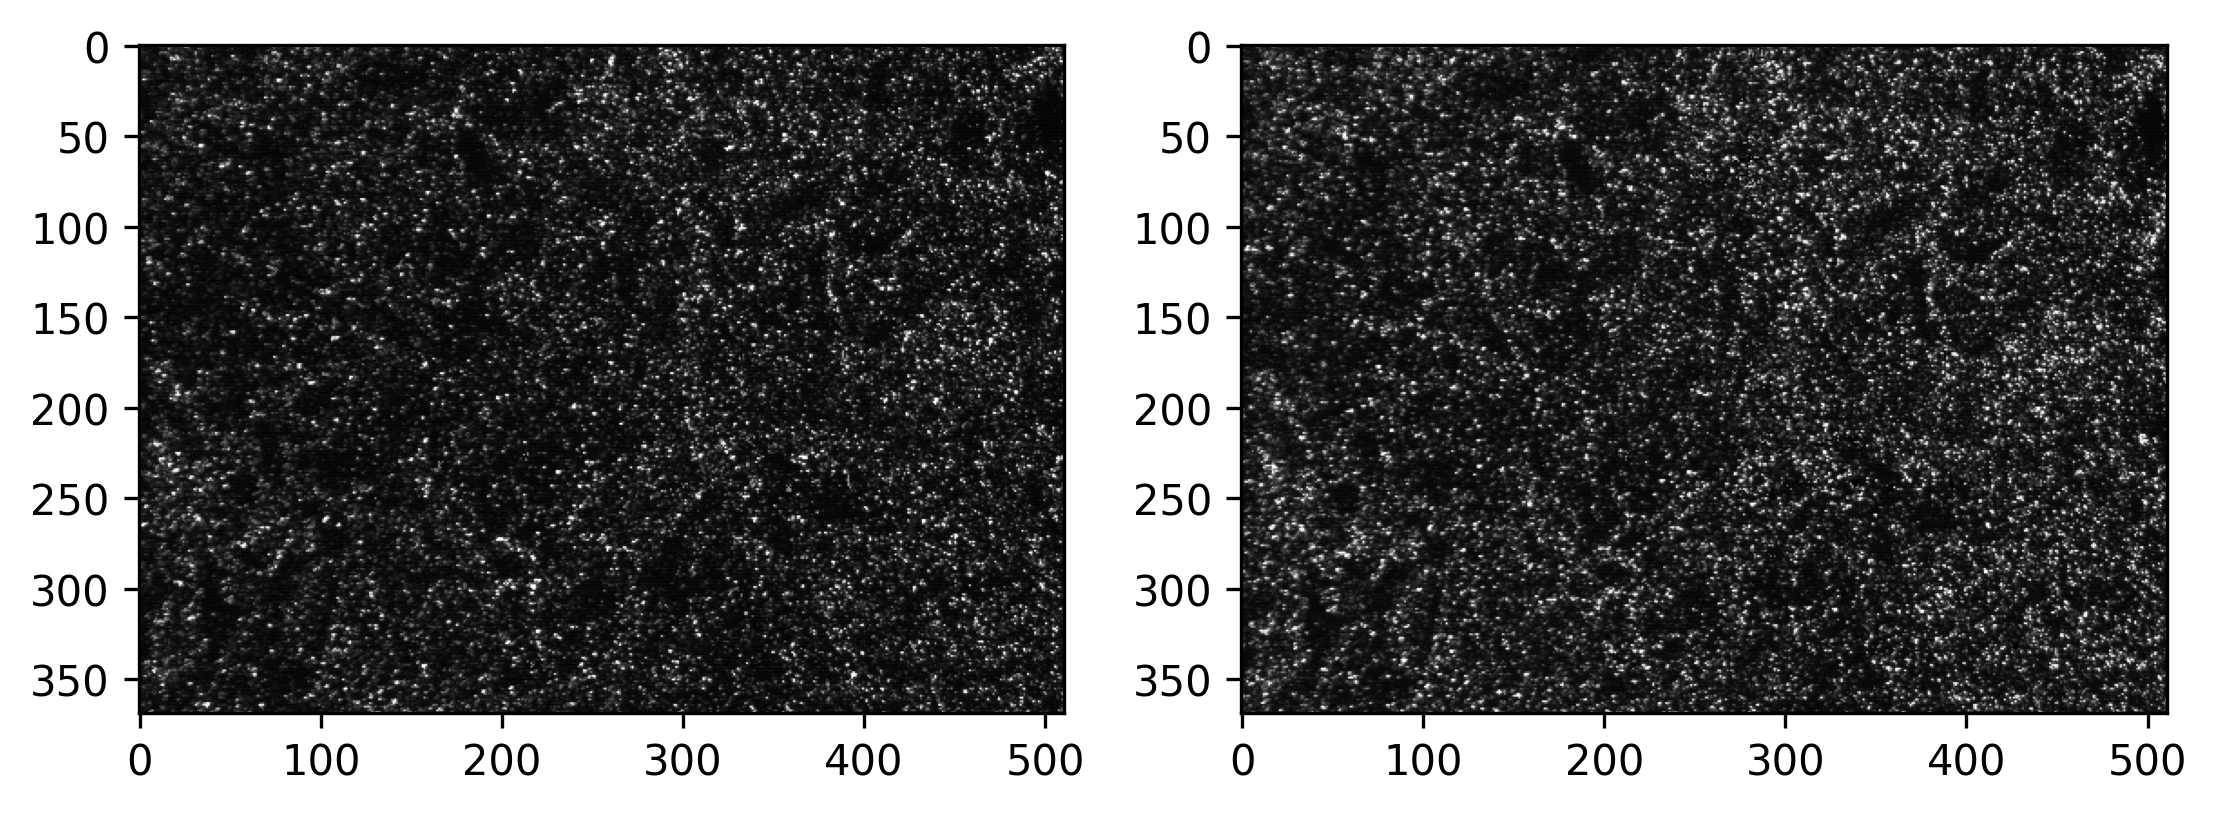

In [ ]:
# Show the particle images.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 9), dpi=300, tight_layout=True)
ax1.imshow(frame_a, cmap='gray')
ax2.imshow(frame_b, cmap='gray')
plt.show()


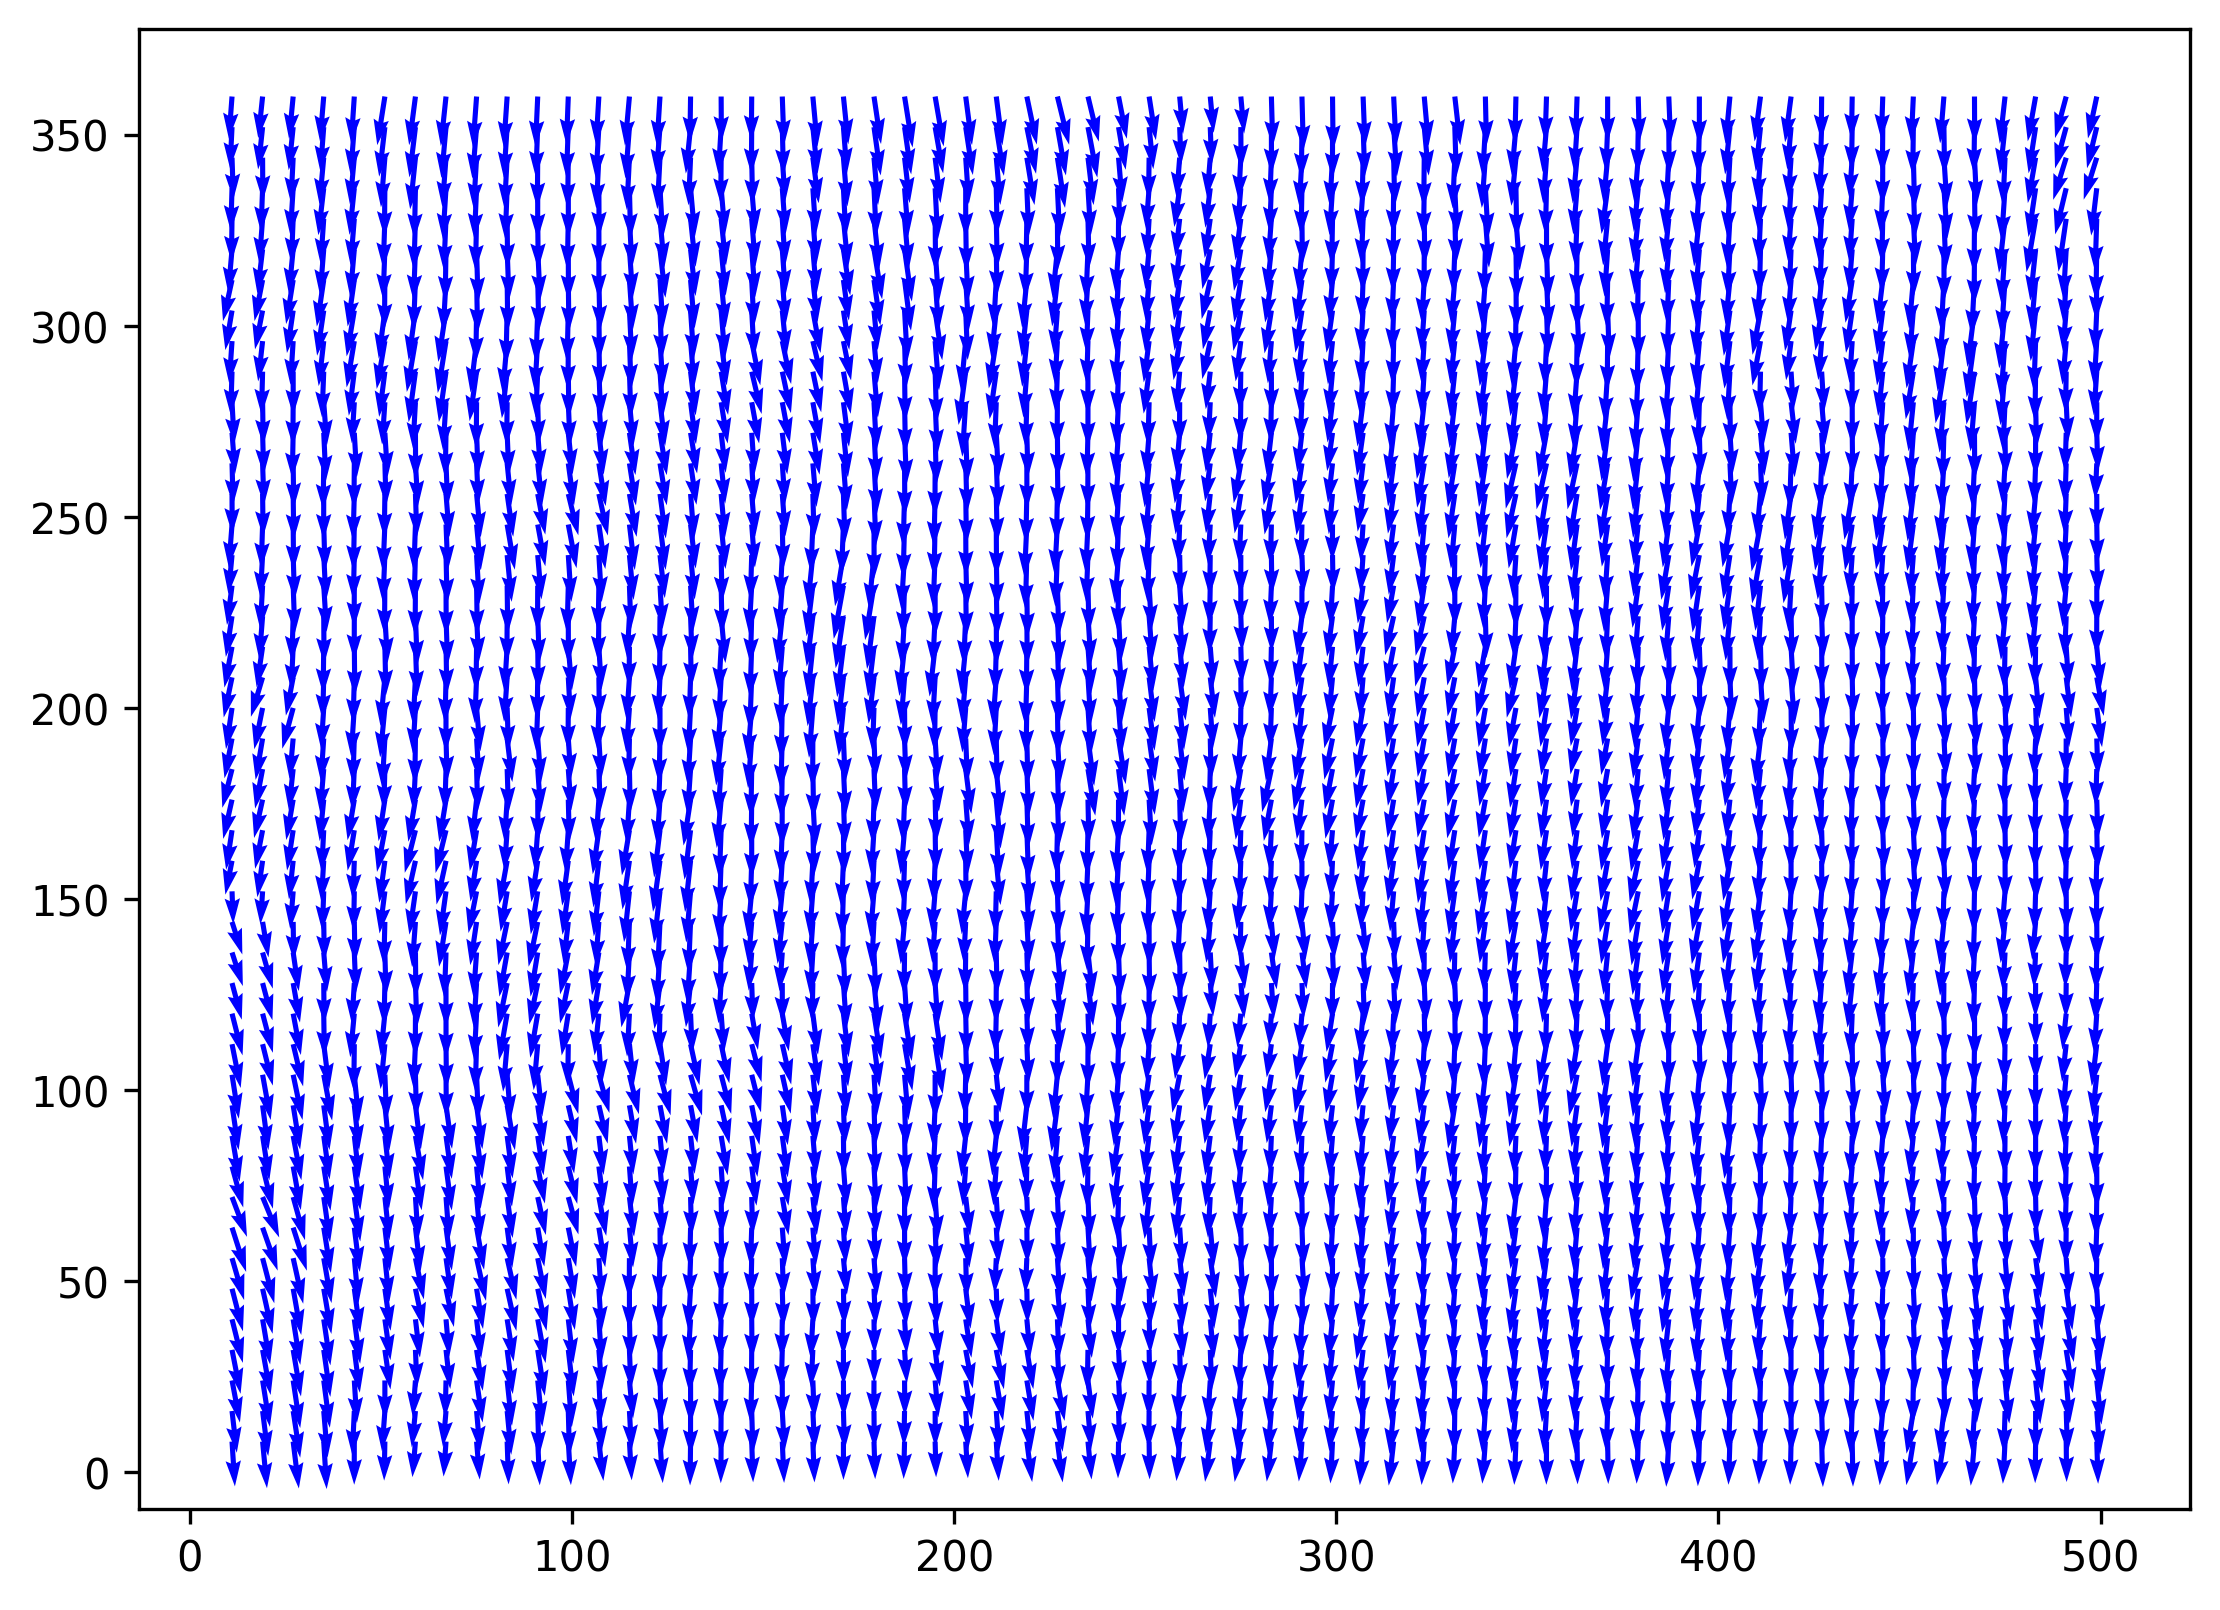

In [ ]:
# The results can be visualized using the openpiv.tools module.
fig, ax = plt.subplots(figsize=(7.5, 9), dpi=300, tight_layout=True)
tools.display_vector_field('exp1_001_gpu.txt', ax=ax, scale=250, width=0.0025)
plt.show()
